In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from tool.config import Cfg
from tool.translate import build_model, process_input, translate
import torch
import onnxruntime
import numpy as np

In [5]:
config = Cfg.load_config_from_file('./config/vgg-seq2seq.yml')
config['cnn']['pretrained']=False
config['device'] = 'cpu'
model, vocab = build_model(config)
weight_path = './weight/seq2seqocr.pth'

c:\Users\z230\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\z230\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
# load weight
model.load_state_dict(torch.load(weight_path, map_location=torch.device(config['device'])))
model = model.eval() 

## Export CNN part

In [4]:
def convert_cnn_part(img, save_path, model, max_seq_length=128, sos_token=1, eos_token=2): 
    with torch.no_grad(): 
        src = model.cnn(img)
        torch.onnx.export(model.cnn, 
                          img, 
                          save_path, 
                          export_params=True, 
                          opset_version=12, 
                          do_constant_folding=True, 
                          verbose=True, 
                          input_names=['img'], 
                          output_names=['output'], 
                          dynamic_axes={'img': {3: 'lenght'}, 'output': {0: 'channel'}})
    
    return src

In [47]:
img = torch.rand(1, 3, 32, 475)
src = convert_cnn_part(img, './weight/cnn.onnx', model)

In [45]:
img = torch.rand(1, 3, 32, 290)
src = convert_cnn_part(img, './weight/cnn123.onnx', model)

In [53]:
print(src.shape)
print(src[0])

torch.Size([236, 1, 256])
tensor([[-5.6706e-02,  1.0057e-01,  4.2346e-02,  3.2915e-03, -4.8635e-02,
          9.0643e-02, -7.3254e-02,  5.5821e-03,  2.6270e-01, -9.1775e-02,
          8.1345e-02, -1.1094e-01,  7.4715e-03,  1.0547e-01,  8.8589e-02,
          4.7154e-02,  2.9565e-02,  1.0230e-01, -1.0234e-01,  5.3444e-03,
          2.9170e-02, -7.0159e-02,  2.3480e-02,  1.9931e-01, -7.7080e-03,
          2.5892e-02,  1.2249e-01, -1.1214e-01,  1.0046e-01,  5.5964e-02,
         -8.1989e-02, -8.1518e-02,  3.7256e-02,  1.3263e-01,  6.3373e-02,
          4.2336e-01,  2.3565e-02, -4.0286e-02, -1.2421e-01, -8.5248e-02,
         -1.2295e-04,  6.9306e-02,  6.2697e-02,  5.0056e-02,  2.8205e-02,
          3.6346e-03,  2.9429e-01, -8.2985e-02,  1.9135e-02,  8.5514e-02,
         -1.3889e-01, -1.4023e-02, -7.1576e-03, -2.5264e-01, -1.1803e-01,
          7.8759e-03, -1.2207e-01, -6.7416e-02, -7.4444e-04,  7.7486e-02,
          4.9645e-02, -8.1011e-03,  6.1303e-02, -1.4124e-02, -3.0959e-02,
         -1.

## Export encoder part

In [49]:
def convert_encoder_part(model, src, save_path): 
    encoder_outputs, hidden = model.transformer.encoder(src) 
    torch.onnx.export(model.transformer.encoder, 
                      src, 
                      save_path, 
                      export_params=True, 
                      opset_version=11, 
                      do_constant_folding=True, 
                      input_names=['src'], 
                      output_names=['encoder_outputs', 'hidden'], 
                      dynamic_axes={'src':{0: "channel_input"}, 'encoder_outputs': {0: 'channel_output'}}) 
    return hidden, encoder_outputs

In [50]:
hidden, encoder_outputs = convert_encoder_part(model, src, './weight/encoder.onnx')

c:\Users\z230\miniforge3\lib\site-packages\torch\onnx\symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [51]:
print(hidden.shape)
print(encoder_outputs.shape)

torch.Size([1, 256])
torch.Size([236, 1, 512])


## Export decoder part

In [54]:
def convert_decoder_part(model, tgt, hidden, encoder_outputs, save_path):
    tgt = tgt[-1]
    print(tgt)
    torch.onnx.export(model.transformer.decoder,
        (tgt, hidden, encoder_outputs),
        save_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['tgt', 'hidden', 'encoder_outputs'],
        output_names=['output', 'hidden_out', 'last'],
        dynamic_axes={'encoder_outputs':{0: "channel_input"},
                    'last': {0: 'channel_output'}})

In [55]:
device = img.device
tgt = torch.LongTensor([[1] * len(img)]).to(device)

In [4]:
img = torch.rand(1, 3, 32, 290)
len(img)

1

In [56]:
convert_decoder_part(model, tgt, hidden, encoder_outputs, './weight/decoder.onnx')

tensor([1])


d:\Hung\Projects\ConvertVietOcr2Onnx\model\seqmodel\seq2seq.py:93: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert (output == hidden).all()
c:\Users\z230\miniforge3\lib\site-packages\torch\onnx\symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [57]:
convert_decoder_part(model, tgt, hidden, encoder_outputs, './weight/decoder123.onnx')


tensor([1])


## Load and check model

In [6]:
import onnx

In [4]:
cnn = onnx.load('./weight/cnn.onnx')
decoder = onnx.load('./weight/encoder.onnx')
encoder = onnx.load('./weight/decoder.onnx')

NameError: name 'onnx' is not defined

In [20]:
# confirm model has valid schema
onnx.checker.check_model(cnn)
onnx.checker.check_model(decoder)
onnx.checker.check_model(encoder)

In [21]:
# # Print a human readable representation of the graph
onnx.helper.printable_graph(encoder.graph)

'graph torch_jit (\n  %tgt[INT64, 1]\n  %hidden[FLOAT, 1x256]\n  %encoder_outputs[FLOAT, channel_inputx1x512]\n) initializers (\n  %attention.attn.bias[FLOAT, 256]\n  %embedding.weight[FLOAT, 233x256]\n  %fc_out.weight[FLOAT, 233x1024]\n  %fc_out.bias[FLOAT, 233]\n  %onnx::Concat_130[INT64, 1]\n  %onnx::MatMul_134[FLOAT, 768x256]\n  %onnx::MatMul_135[FLOAT, 256x1]\n  %onnx::GRU_153[FLOAT, 1x768x768]\n  %onnx::GRU_154[FLOAT, 1x768x256]\n  %onnx::GRU_155[FLOAT, 1x1536]\n) {\n  %onnx::Concat_131 = Identity(%onnx::Concat_130)\n  %onnx::Concat_133 = Identity(%onnx::Concat_131)\n  %onnx::Concat_132 = Identity(%onnx::Concat_130)\n  %input = Unsqueeze[axes = [0]](%tgt)\n  %input.3 = Gather(%embedding.weight, %input)\n  %onnx::Gather_15 = Shape(%encoder_outputs)\n  %onnx::Gather_16 = Constant[value = <Scalar Tensor []>]()\n  %onnx::Unsqueeze_17 = Gather[axis = 0](%onnx::Gather_15, %onnx::Gather_16)\n  %onnx::Expand_18 = Unsqueeze[axes = [1]](%hidden)\n  %onnx::Concat_22 = Unsqueeze[axes = [0]](

## Inference directly

In [6]:
img = Image.open('../prj8.1-id-card-tools/algorithm/16.jpg')
img = process_input(img, config['dataset']['image_height'], 
                config['dataset']['image_min_width'], config['dataset']['image_max_width'])  
img = img.to(config['device'])

In [8]:
print(img.shape)
print(len(img))

torch.Size([1, 3, 32, 240])
1


tensor([0.4667, 0.4627, 0.4471, 0.4667, 0.4667, 0.4706, 0.4588, 0.4510, 0.4588,
        0.4824, 0.4902, 0.4667, 0.4745, 0.4824, 0.4824, 0.4784, 0.4863, 0.4824,
        0.4824, 0.4902, 0.4824, 0.4784, 0.4784, 0.4784, 0.4902, 0.4863, 0.4824,
        0.4902, 0.4863, 0.4863, 0.4902, 0.4980, 0.5020, 0.4941, 0.5020, 0.5098,
        0.5059, 0.5059, 0.5020, 0.5137, 0.5137, 0.5059, 0.4902, 0.4941, 0.4941,
        0.4941, 0.4980, 0.5020, 0.5059, 0.5098, 0.5059, 0.5059, 0.5020, 0.4980,
        0.4941, 0.5020, 0.5059, 0.5137, 0.5216, 0.5137, 0.5020, 0.5020, 0.5020,
        0.5059, 0.5176, 0.5098, 0.5059, 0.5059, 0.5176, 0.5216, 0.5098, 0.5137,
        0.5255, 0.5216, 0.5098, 0.4980, 0.4980, 0.4863, 0.4510, 0.4118, 0.3686,
        0.3569, 0.3804, 0.4078, 0.4510, 0.4863, 0.4980, 0.5176, 0.5294, 0.5294,
        0.5216, 0.5333, 0.5333, 0.5255, 0.5294, 0.5333, 0.5255, 0.5176, 0.5216,
        0.5255, 0.5216, 0.5216, 0.5333, 0.5373, 0.5373, 0.5333, 0.5333, 0.5294,
        0.5255, 0.5255, 0.5333, 0.5412, 

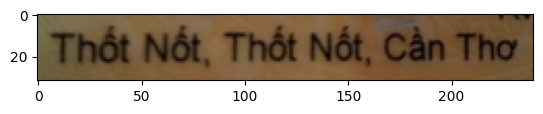

In [15]:
print(img[0][0][0])
plt.imshow(np.transpose(img[0], (1,2,0)))

In [10]:
s = translate(img, model)[0].tolist()
s = vocab.decode(s)
s

'Thốt Nốt, Thốt Nốt, Cần Thơ'

## Inference with ONNX Runtime's Python API

In [7]:
# create inference session
cnn_session = onnxruntime.InferenceSession("./weight/cnn.onnx")
encoder_session = onnxruntime.InferenceSession("./weight/encoder.onnx")
decoder_session = onnxruntime.InferenceSession("./weight/decoder.onnx")

In [9]:
import time
def translate_onnx(img, session, max_seq_length=128, sos_token=1, eos_token=2):
    """data: BxCxHxW"""
    cnn_session, encoder_session, decoder_session = session

    # create cnn input
    cnn_input = {cnn_session.get_inputs()[0].name: img}
    src = cnn_session.run(None, cnn_input)

    # create encoder input
    encoder_input = {encoder_session.get_inputs()[0].name: src[0]}
    encoder_outputs, hidden = encoder_session.run(None, encoder_input)

    translated_sentence = [[sos_token] * len(img)]

    max_length = 0

    while max_length <= max_seq_length and not all(np.any(np.asarray(translated_sentence).T == eos_token, axis=1)):
        tgt_inp = translated_sentence
        decoder_input = {decoder_session.get_inputs()[0].name: tgt_inp[-1], decoder_session.get_inputs()[1].name: hidden, decoder_session.get_inputs()[2].name: encoder_outputs}

        output, hidden, _ = decoder_session.run(None, decoder_input)

        output = np.expand_dims(output, axis=1)

        output = torch.Tensor(output)

        values, indices = torch.topk(output, 1)
        indices = indices[:, -1, 0]
        indices = indices.tolist()

        translated_sentence.append(indices)
        max_length += 1

        del output
    
    translated_sentence = np.asarray(translated_sentence).T
    
    return translated_sentence

In [17]:
cnn_input = {cnn_session.get_inputs()[0].name: np.array(img)}
src = cnn_session.run(None, cnn_input)
print(np.shape(src))
print(src[0])

(1, 120, 1, 256)
[[[-0.07372621  0.09173683  0.05526305 ... -0.1273543  -0.09739669
    0.21116973]]

 [[-0.00561377  0.02310089 -0.0184825  ...  0.03480972  0.01481546
    0.09960299]]

 [[-0.00782682  0.08407912 -0.02092777 ...  0.13797507 -0.0921014
    0.0907843 ]]

 ...

 [[ 0.18265617  0.2209473  -0.09452756 ...  0.20331839 -0.17025083
    0.24646181]]

 [[ 0.17050093  0.18558167 -0.03175992 ... -0.01648795 -0.12564254
    0.12240183]]

 [[ 0.16716224  0.14826965 -0.00096989 ... -0.11169431 -0.17000443
    0.06073988]]]


In [45]:
encoder_input = {encoder_session.get_inputs()[0].name: src[0]}
encoder_outputs, hidden = encoder_session.run(None, encoder_input)
print(np.shape(encoder_outputs))
print(np.shape(hidden))
print(encoder_outputs)

(120, 1, 512)
(1, 256)
[[[-0.02742085 -0.00201841  0.10276211 ... -0.04756666  0.50088286
   -0.3966113 ]]

 [[-0.06561998  0.00559155  0.22463742 ... -0.03819258  0.49505535
   -0.45395043]]

 [[-0.11232643  0.00936338  0.29537213 ... -0.29157156  0.4737768
   -0.4056033 ]]

 ...

 [[-0.35410458  0.21591268 -0.16574018 ... -0.05805764  0.36042073
    0.03458491]]

 [[-0.35066736  0.24728529 -0.20085132 ... -0.02513563  0.28417662
    0.03539183]]

 [[-0.34844178  0.29230937 -0.24435979 ... -0.0230902   0.15061843
    0.01252212]]]


In [10]:
session = (cnn_session, encoder_session, decoder_session)
s = translate_onnx(np.array(img), session)[0].tolist()
s = vocab.decode(s)
s

cnn  0.05596733093261719
encoder  0.004995822906494141
decoder  0.09994363784790039


'Thốt Nốt, Thốt Nốt, Cần Thơ'

In [17]:
session = (cnn_session, encoder_session, decoder_session)
print(translate_onnx(np.array(img), session)[0].tolist())

[[  1]
 [145]
 [ 76]
 [120]
 [144]
 [232]
 [ 99]
 [120]
 [144]
 [211]
 [232]
 [145]
 [ 76]
 [120]
 [144]
 [232]
 [ 99]
 [120]
 [144]
 [211]
 [232]
 [ 43]
 [ 30]
 [ 98]
 [232]
 [145]
 [ 76]
 [124]
 [  2]]
[1, 145, 76, 120, 144, 232, 99, 120, 144, 211, 232, 145, 76, 120, 144, 232, 99, 120, 144, 211, 232, 43, 30, 98, 232, 145, 76, 124, 2]


In [28]:
print(translate(img, model)[0].tolist())
print(vocab.decode(translate(img, model)[0].tolist()))

[1, 145, 76, 120, 144, 232, 99, 120, 144, 211, 232, 145, 76, 120, 144, 232, 99, 120, 144, 211, 232, 43, 30, 98, 232, 145, 76, 124, 2]
Thốt Nốt, Thốt Nốt, Cần Thơ


In [1]:
import torch
torch.__version__

'2.2.1+cu118'

In [2]:
import torchvision
torchvision.__version__

'0.17.1+cu118'

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
